In [ ]:
options(width = 700)
knitr::opts_chunk$set(warning = FALSE, message = FALSE, out.width = "100%",
                      fig.showtext = TRUE, retina = 1)


*Last update: 2022-01-15*


## Introduction

[I don't care, just show me the content!](#toc)

Dans ce tutoriel, vous apprendrez à reproduire l'une des visualisations de données les plus célèbres au monde, qui a été développée par Hans Rosling : 

Hans Rosling était un professeur de santé internationale et un porte-parole du progrès humain. Par exemple, contrairement à ce que l'on croit généralement, la pauvreté dans le monde a énormément diminué au cours des dernières décennies. La visualisation que vous pouvez voir ci-dessus est l'un des nombreux exemples qui montrent comment la vie sur terre s'est améliorée au cours des dernières décennies. Le nuage de points illustre la relation entre le revenu par habitant et l'espérance de vie en jusqu'en 2007.

L'objectif de ce tutoriel est de reproduire cette célèbre visualisation de données et d'utiliser des techniques plus complexes dans ggplot2 pour ajouter une visualisation dans une visualisation. 


## Préparation {#prep}

* Vous devez charger les package suivants pour exécuter le tutoriel complet :
(Pour des raisons pédagogiques et si les participants sautent à n'importe quel graphe, on charge le package nécessaire à côté de `{ggplot2}` dans la section respective).


In [36]:
# install CRAN packages

library(tidyverse)
library(gapminder)
library(ggthemes)
library(countrycode)
library(ggpp)
library(ggrepel)
library(gganimate)


ERROR: Error in library(ggrepel): there is no package called ‘ggrepel’


## Le jeu de données {#data}

Tout d'abord, nous avons besoin des données gapminder. Heureusement, il existe un package gapminder dans R pour cela. Comme d'habitude, nous devons d'abord charger tous les packages nécessaires à la visualisation.


In [11]:
library(tidyverse)
library(gapminder)

gapminder_cleaned <- 
  gapminder %>% 
  # filter(year == "2007") %>% 
  mutate(
    pop2 = pop + 1,
    continent = case_when(
      continent == "Oceania" ~ "Asia",
      TRUE ~ as.character(continent)
    ) %>% as.factor %>% 
      fct_relevel("Asia", "Americas", "Europe", "Africa"),
    year = as.integer(year),
    year_label = as.character(year),
    country_label = ifelse(str_detect(country, "France"), "France", NA)
  )


## Afficher les données



In [12]:
head(gapminder_cleaned, 10)



country     continent year lifeExp pop      gdpPercap pop2     year_label
1  Afghanistan Asia      1952 28.801   8425333 779.4453   8425334 1952      
2  Afghanistan Asia      1957 30.332   9240934 820.8530   9240935 1957      
3  Afghanistan Asia      1962 31.997  10267083 853.1007  10267084 1962      
4  Afghanistan Asia      1967 34.020  11537966 836.1971  11537967 1967      
5  Afghanistan Asia      1972 36.088  13079460 739.9811  13079461 1972      
6  Afghanistan Asia      1977 38.438  14880372 786.1134  14880373 1977      
7  Afghanistan Asia      1982 39.854  12881816 978.0114  12881817 1982      
8  Afghanistan Asia      1987 40.822  13867957 852.3959  13867958 1987      
9  Afghanistan Asia      1992 41.674  16317921 649.3414  16317922 1992      
10 Afghanistan Asia      1997 41.763  22227415 635.3414  22227416 1997      
   country_label
1  NA           
2  NA           
3  NA           
4  NA           
5  NA           
6  NA           
7  NA           
8  NA           
9  NA           
10 NA

## Le package {ggplot2} {#ggplot}

> `ggplot2` est un système pour créer des graphiques de manière déclarative, basé sur [The Grammar of Graphics] (https://link.springer.com/chapter/10.1007/978-3-642-21551-3_13). Vous fournissez les données, dites à `ggplot2` comment faire correspondre les variables à l'esthétique, quelles primitives graphiques utiliser, et il s'occupe des détails.

Un ggplot est construit à partir de quelques éléments de base :

1.	**Données** :
Les données brutes que vous voulez tracer.
2.	**Géométries** `geom_` :
Les formes géométriques qui représenteront les données.
3.	**Esthétique** `aes()` :
Esthétique des objets géométriques et statistiques, comme la position, la couleur, la taille, la forme et la transparence.
4.	**Echelles** `scale_` :
Les cartes entre les données et les dimensions esthétiques, telles que la plage de données à la largeur du graphique ou les valeurs des facteurs aux couleurs.
5.	**Transformations statistiques** `stat_` :
Résumés statistiques des données, tels que les quantiles, les courbes ajustées, et les sommes.
6.	**Système de coordonnées** `coord_` :
La transformation utilisée pour mettre en correspondance les coordonnées des données dans le plan du rectangle de données.
7.	**Facettes** `facet_` :
L'arrangement des données dans une grille de parcelles.
8.	**Thèmes visuels** `theme()` :
Les défauts visuels globaux d'un tracé, tels que le fond, les grilles, les axes, la police de caractères par défaut, les tailles et les couleurs.

💡 **Le nombre d'éléments peut varier en fonction de la façon dont vous les regroupez.**

## Créer une figure informative {#default}

Tout d'abord, pour pouvoir utiliser les fonctionnalités de `{ggplot2}`, nous devons charger le package (que nous pouvons également charger via la [tidyverse package collection](https://www.tidyverse.org/)) :

La syntaxe de `{ggplot2}` est différente de celle du R de base. En accord avec les éléments de base, un ggplot par défaut a besoin de trois choses que vous devez spécifier : les *données*, l'*esthétique*, et une *géométrie*. On commence toujours à définir un objet de traçage en appelant `ggplot(data = df)` qui indique simplement à `{ggplot2}` que l'on va travailler avec ces données. Dans la plupart des cas, vous voudrez tracer deux variables, l'une sur l'axe des x et l'autre sur l'axe des y. Il s'agit d'une *esthétique de positionnement*. Il s'agit d'une *esthétique positionnelle* et donc nous ajoutons `aes(x = var1, y = var2)` à l'appel `ggplot()` (oui, le `aes()` signifie esthétique). Cependant, il y a aussi des cas où l'on doit spécifier une, voire trois variables ou plus.

💡 **On spécifie les données *outside* `aes()` et on ajoute les variables auxquelles ggplot associe l'esthétique *inside* `aes()`.**

Ici, nous indexons la variable `gdpPercap` à la position x et la variable `lifeExp` à la position y. Plus tard, nous affecterons également des variables à toutes sortes d'autres caractéristiques esthétiques telles que la couleur, la taille et la forme.


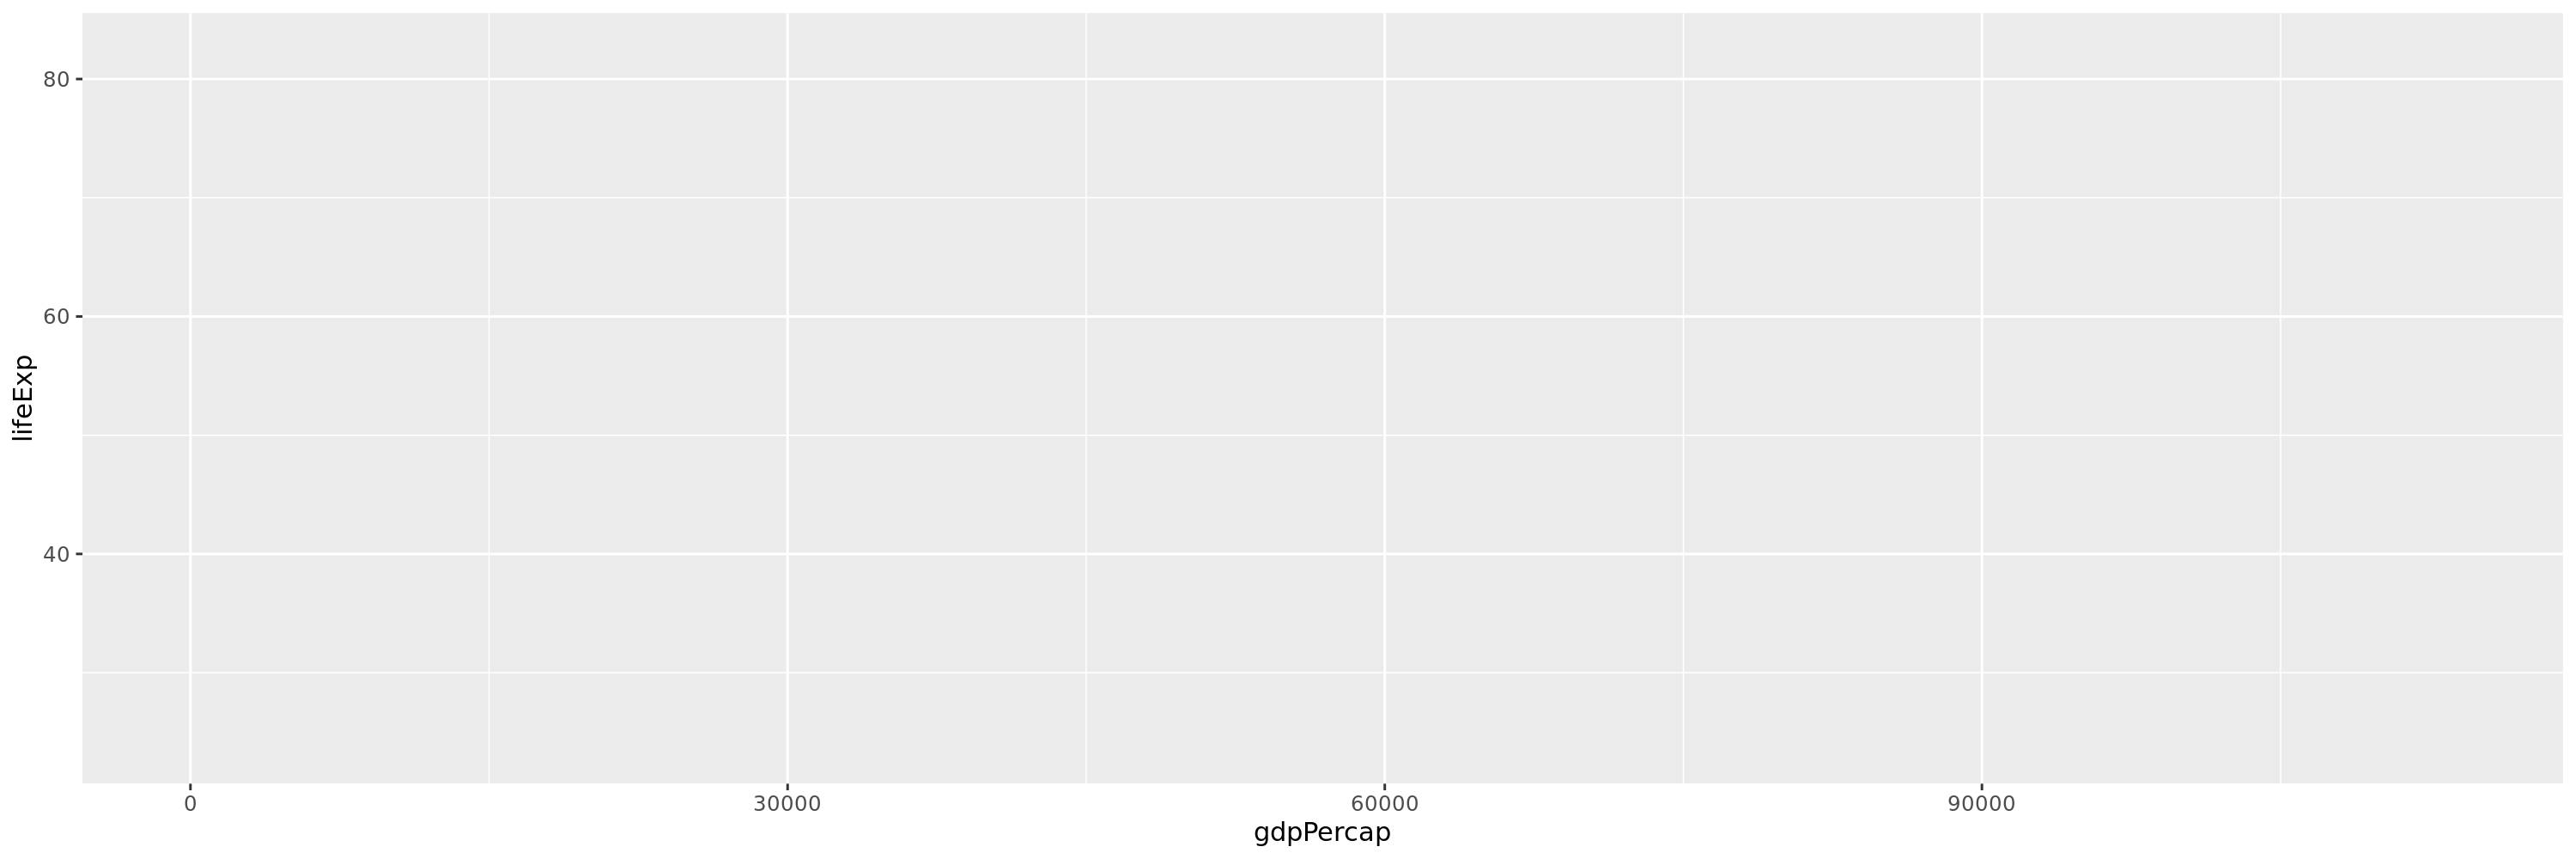

In [18]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
  
ggplot(data = gapminder_cleaned, aes(x = gdpPercap, y = lifeExp))  +




Hm, seul un panneau est créé lors de l'exécution. Pourquoi ? C'est parce que `{ggplot2}` ne sait pas *comment* nous voulons tracer ces données - nous devons encore fournir une géométrie !

`ggplot2` vous permet de stocker le `ggobject` actuel dans une variable de votre choix en l'assignant à une variable, dans notre cas appelée `gapminder_plot`. Vous pouvez étendre ce `ggobjet` plus tard en ajoutant d'autres couches, soit en une seule fois, soit en l'assignant à la même ou à une autre variable.

💡 **En utilisant des parenthèses lors de l'assignation d'un objet, l'objet sera imprimé immédiatement (au lieu d'écrire `g <- ggplot(...)` et ensuite `g` on écrit simplement `(g <- ggplot(...))`).**.

Il y a beaucoup, beaucoup de géométries différentes (appelées *geoms* parce que chaque fonction commence généralement par `geom_`) que l'on peut ajouter à un ggplot par défaut (voir [ici](https://ggplot2.tidyverse.org/reference/) pour une liste complète) et encore plus fournies par des paquets d'extension (voir [ici](https://exts.ggplot2.tidyverse.org/) pour une collection de paquets d'extension). Indiquons à `{ggplot2}` quel style nous voulons utiliser, par exemple en ajoutant `geom_point()` pour créer un nuage de points :


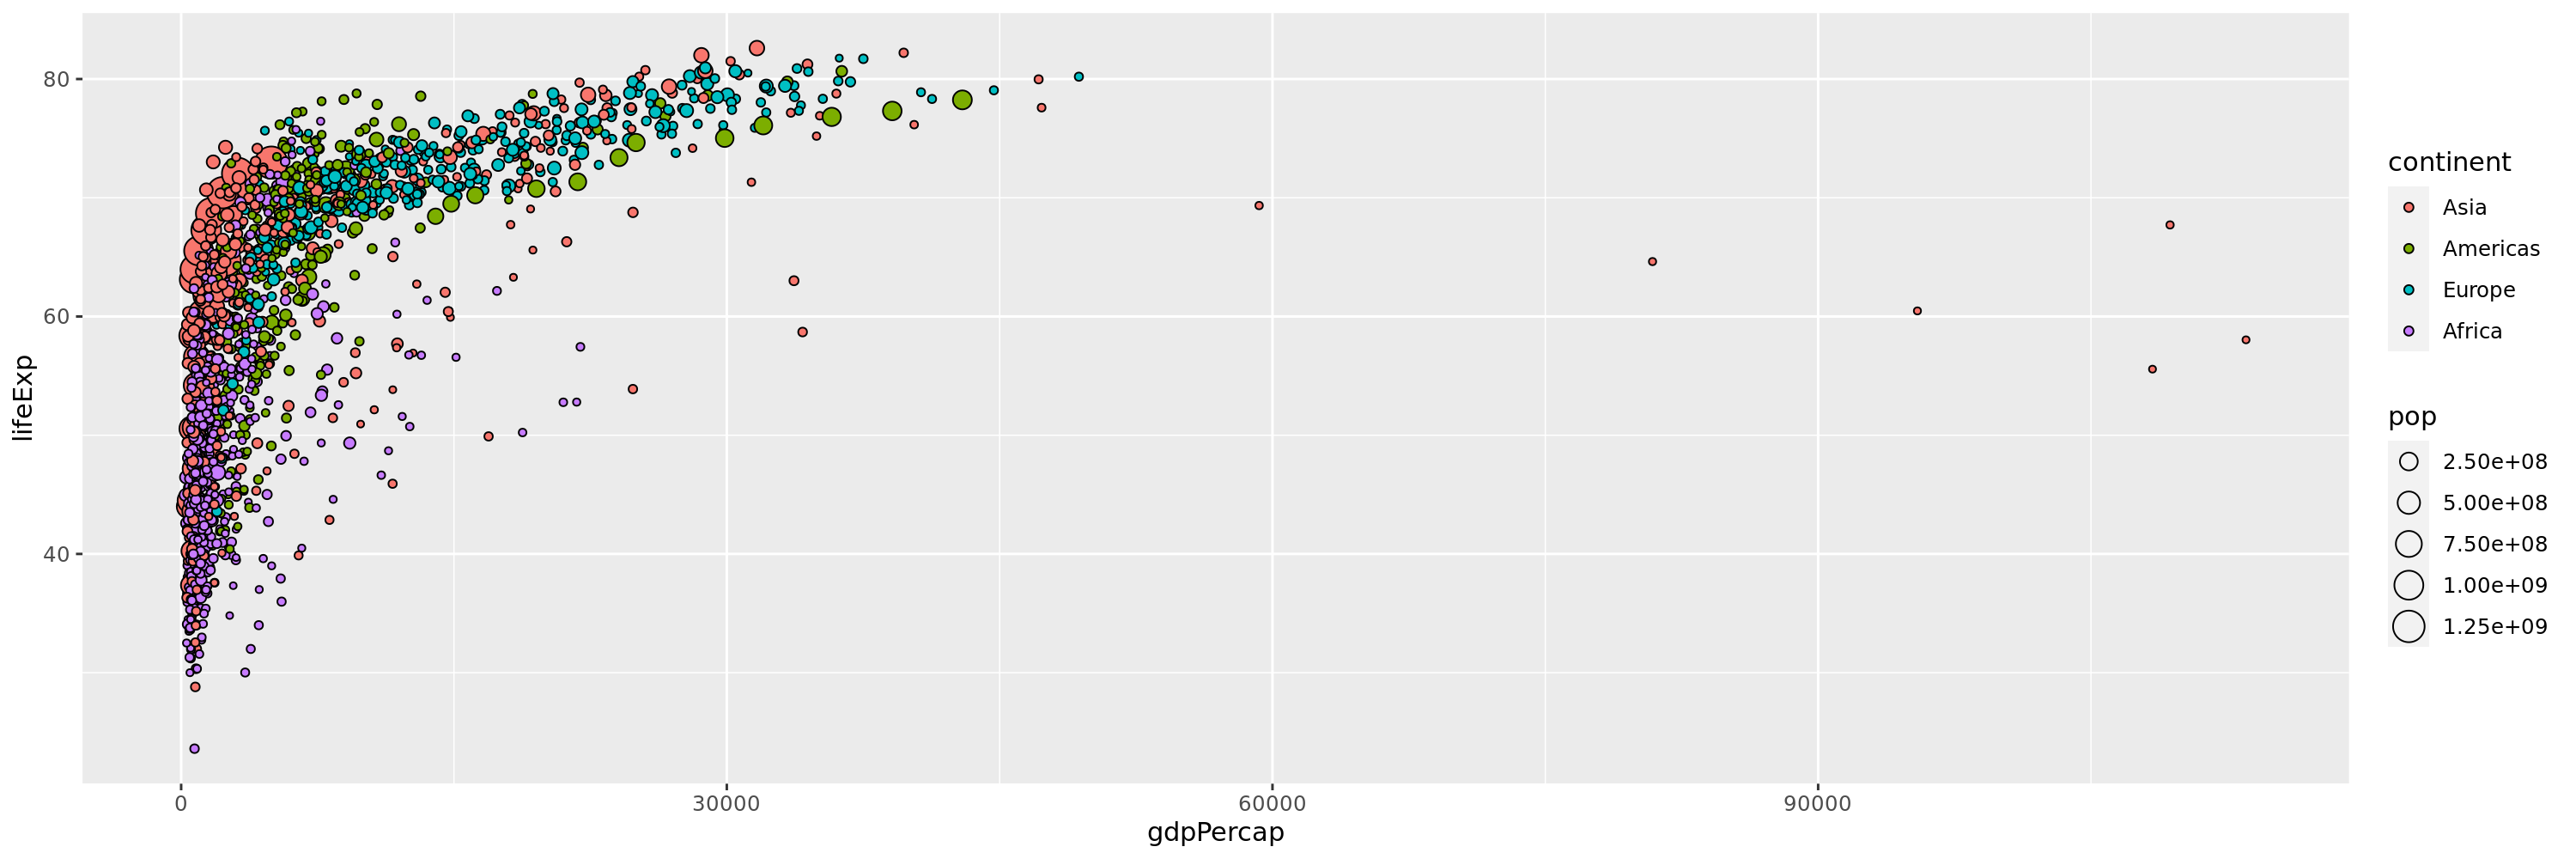

In [21]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)

gapminder_plot <-
    ggplot(data = gapminder_cleaned, aes(x = gdpPercap, y = lifeExp)) +
  geom_point(aes(size = pop, fill = continent), shape = 21) 
  
gapminder_plot


On peut aussi combiner plusieurs couches géométriques - et c'est là que la magie et le plaisir commence !
On peut aussi ajuster les axes.

##### Ajuster les axes 

Ajustons l'axe "x"


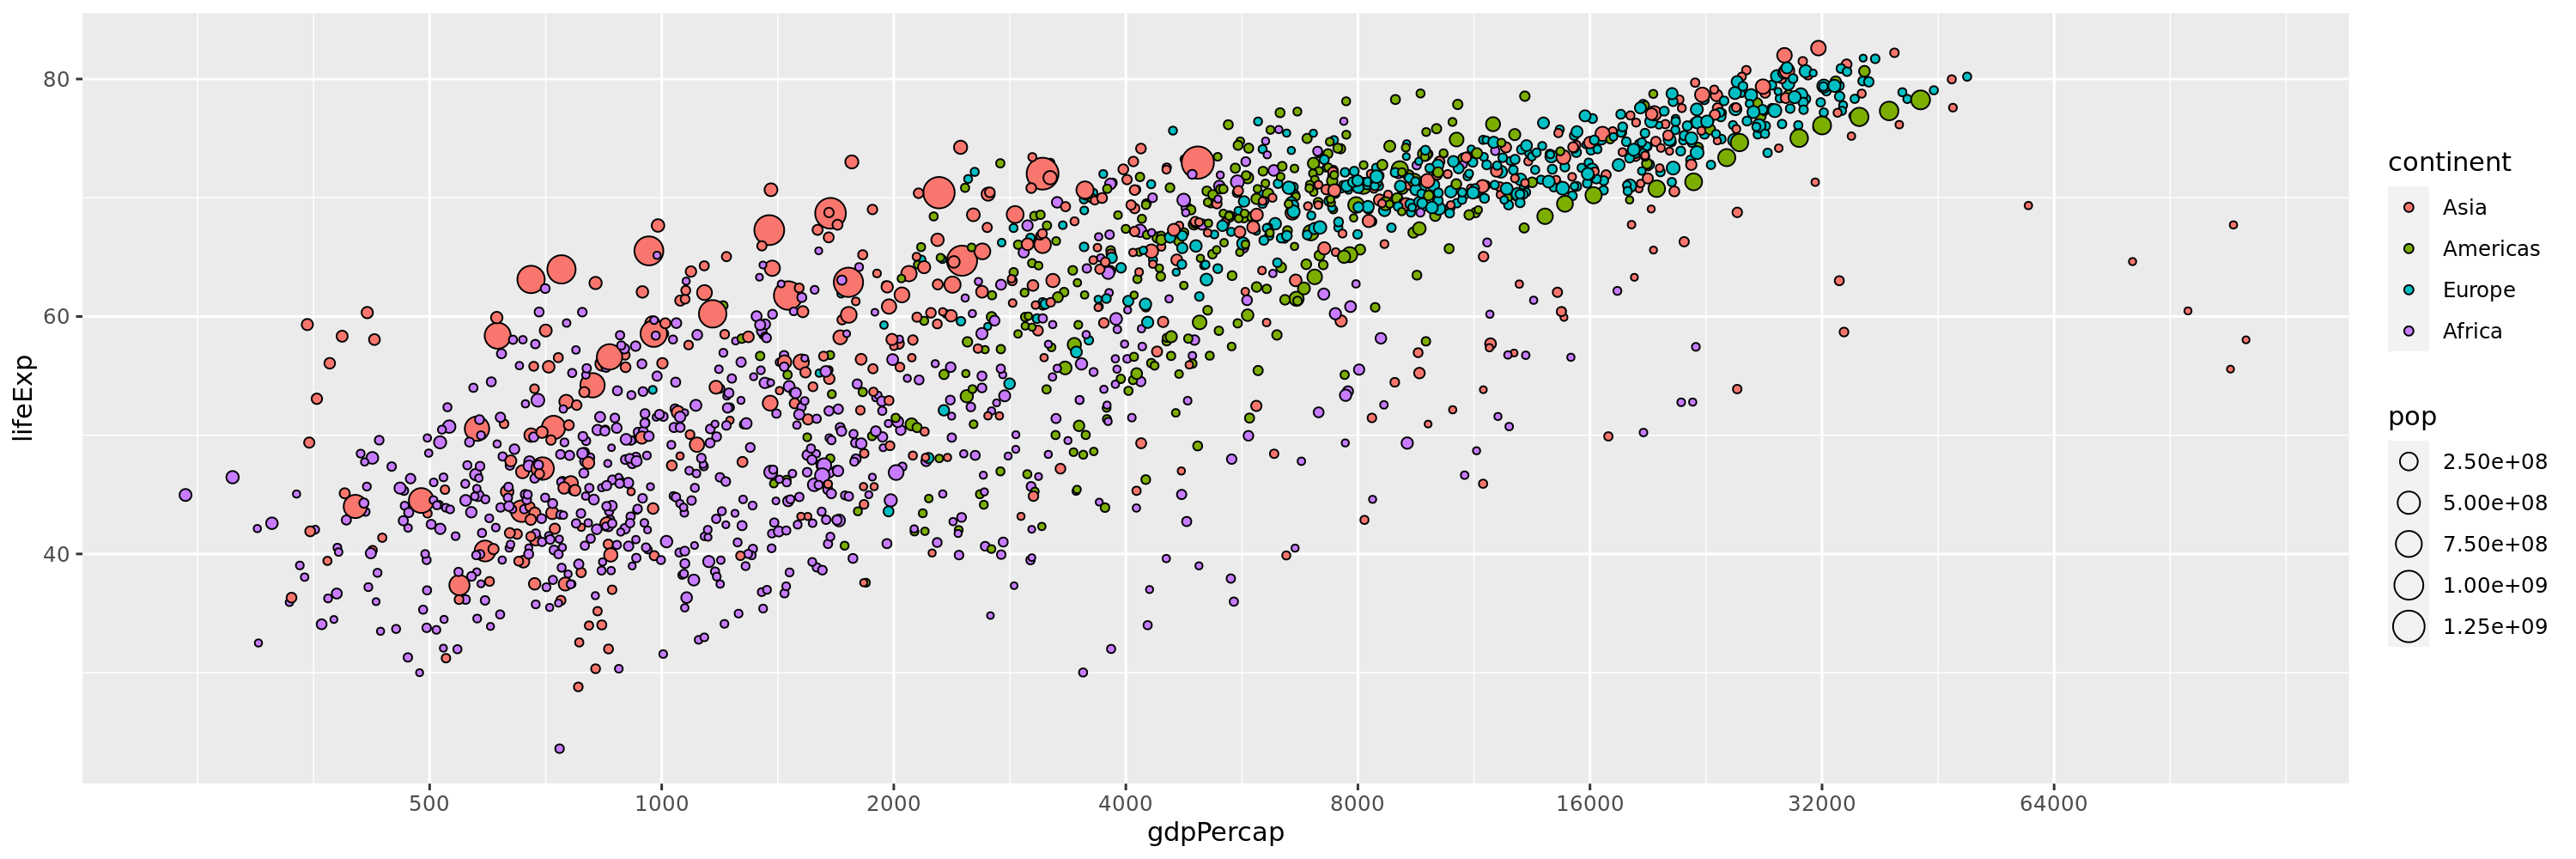

In [22]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) 


Ajustons l'axe "y"



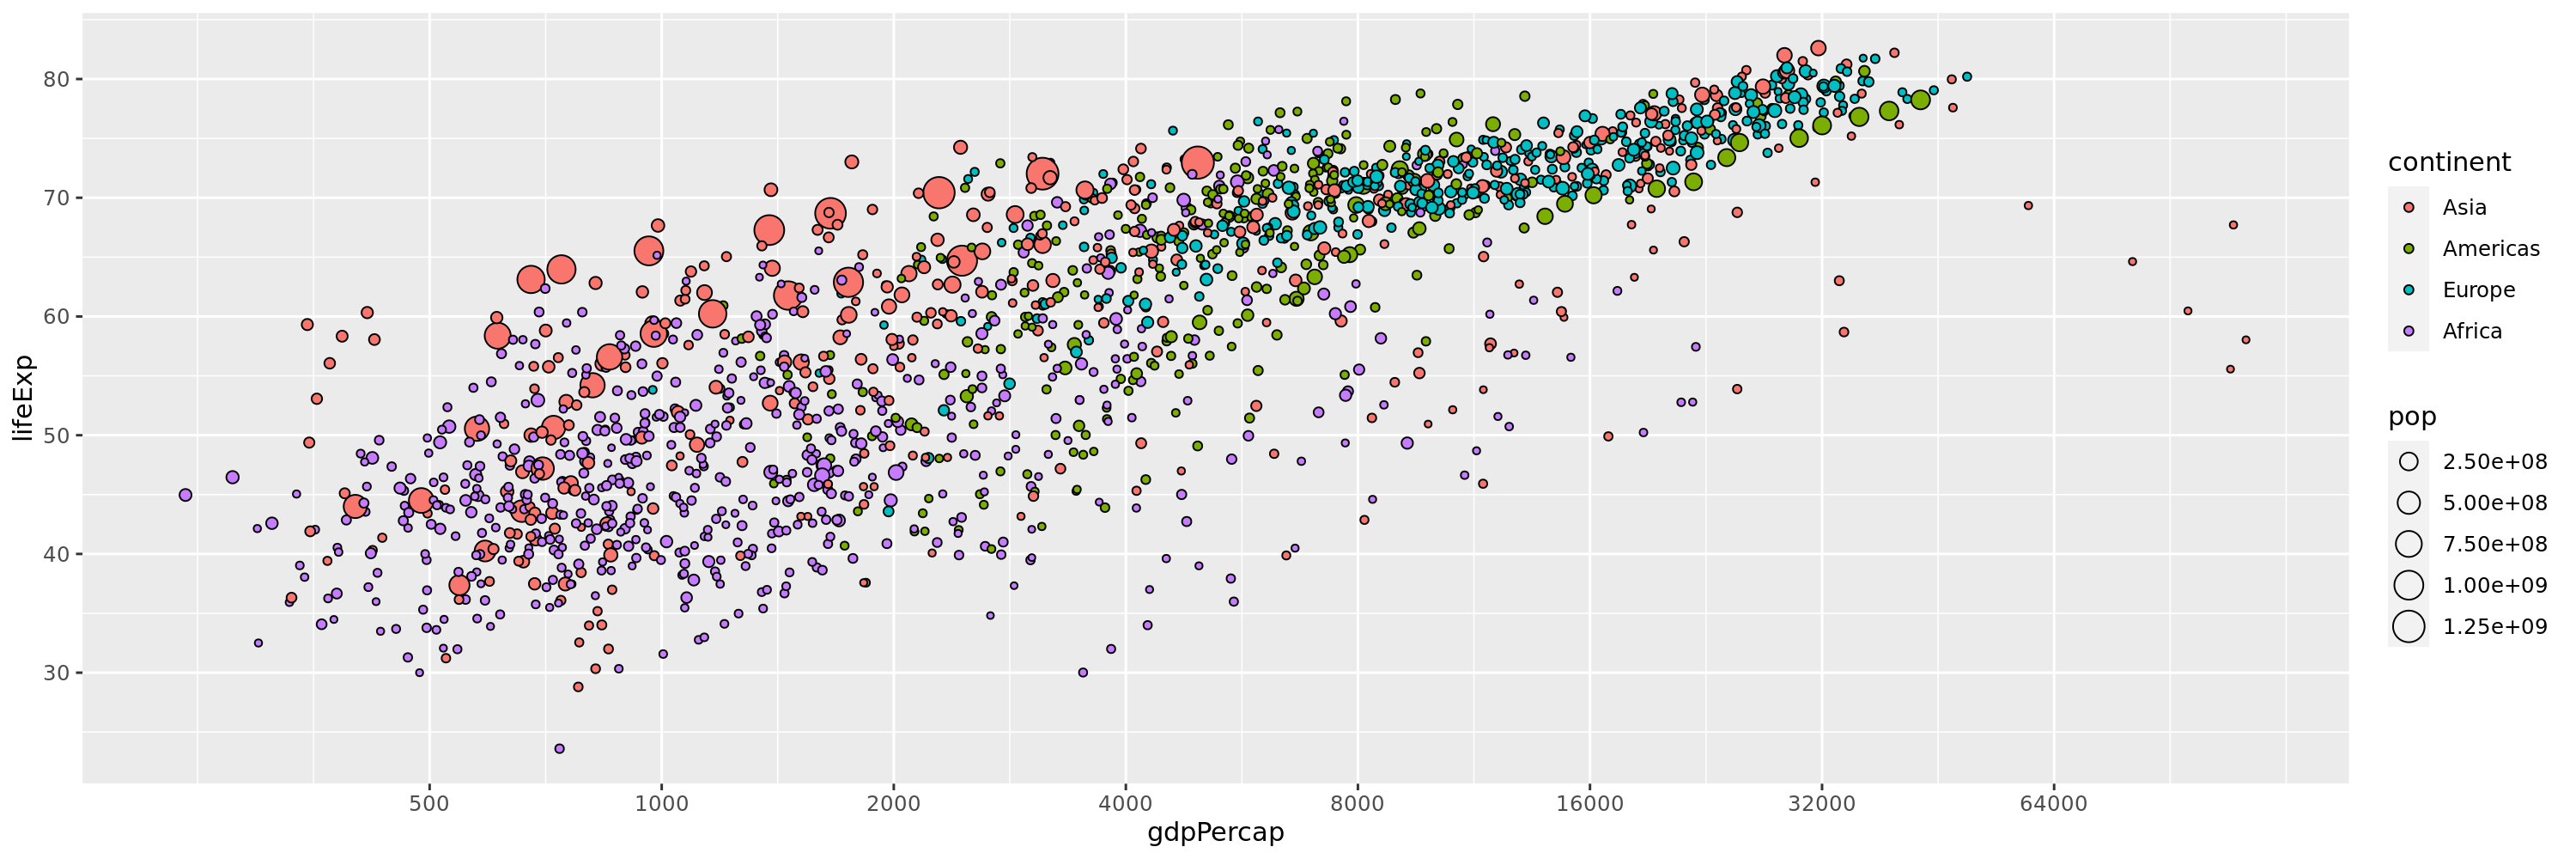

In [23]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) 
  


💡 **`{ggplot2}` comprend à la fois `color` et `colour` ainsi que la version courte `col`.**

Chaque geom vient avec ses propres propriétés (appelées *arguments*) et le même argument peut entraîner un changement différent selon le géom que vous utilisez.


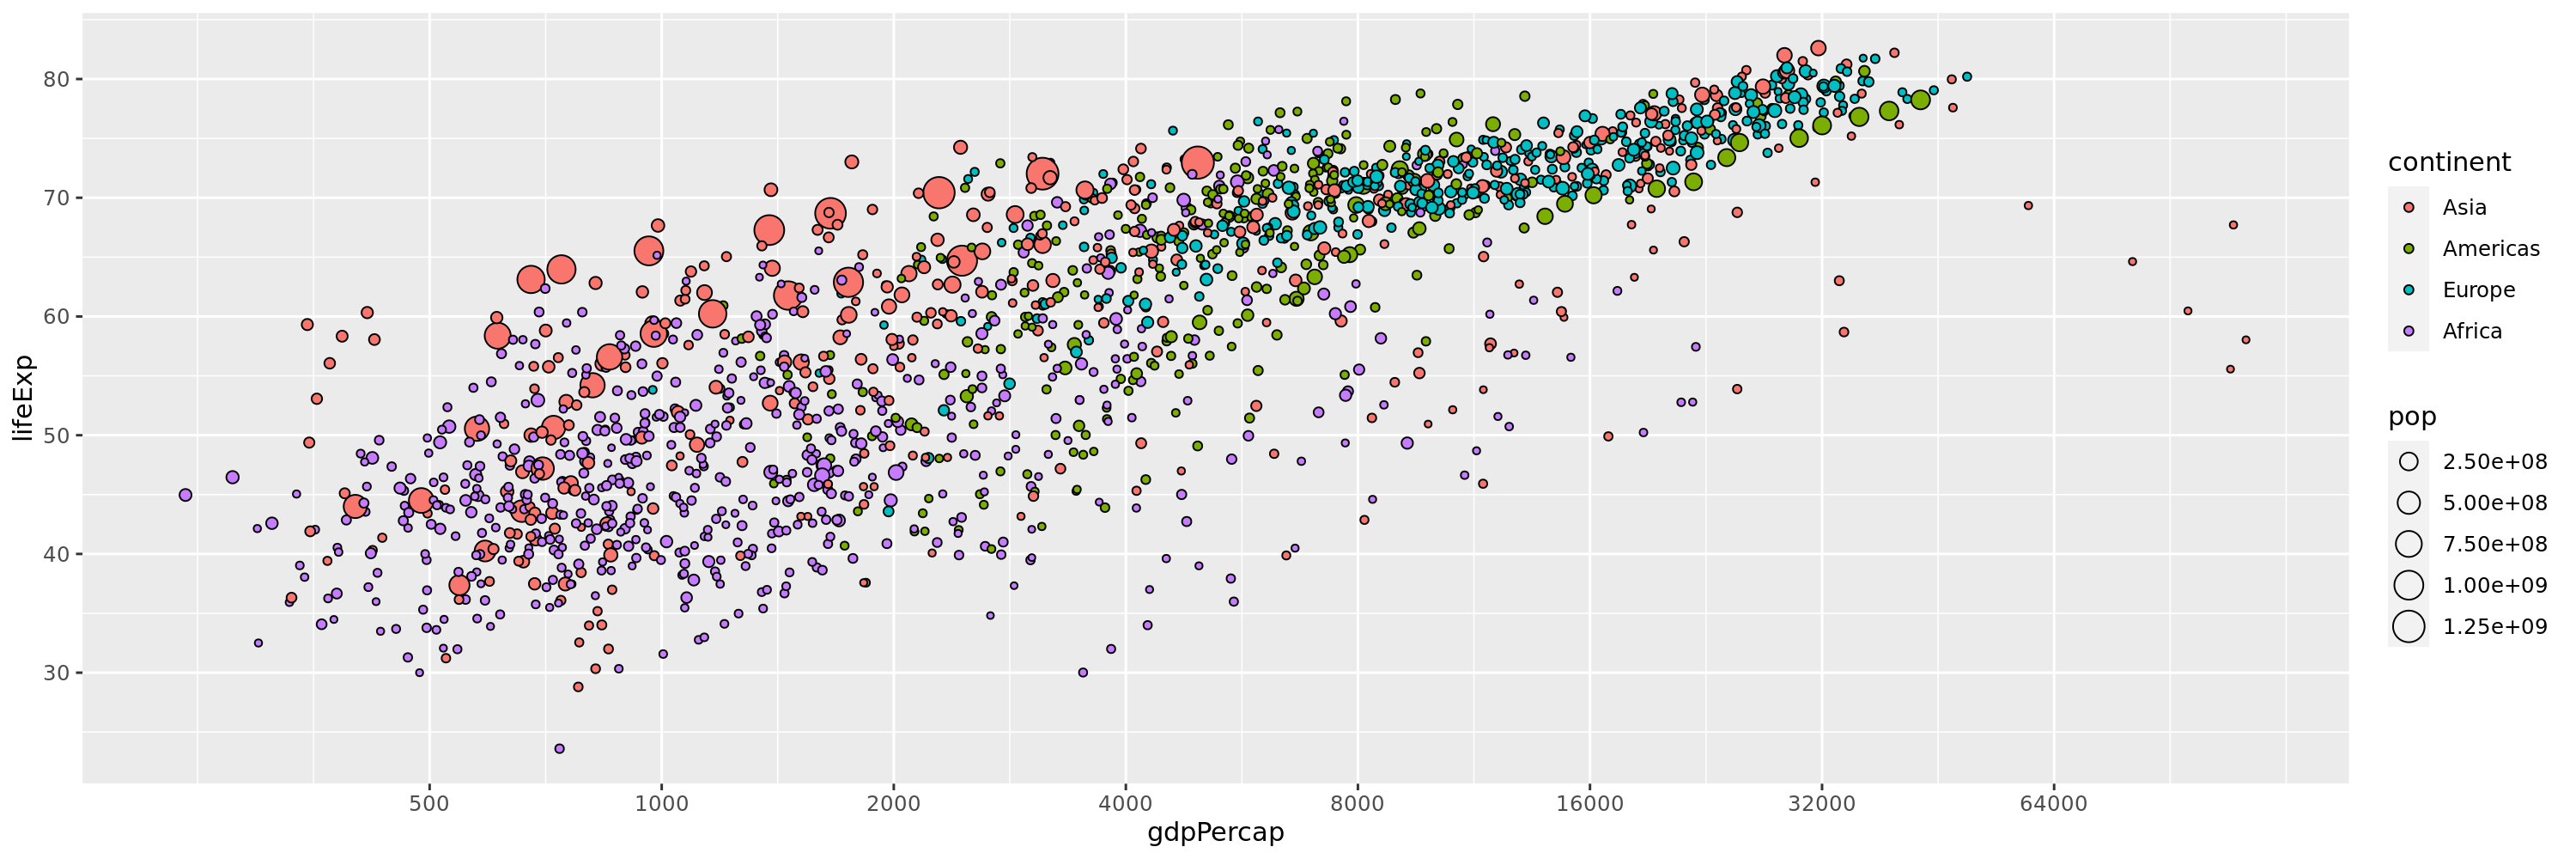

In [24]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) 


Normalisons le diamètre des point en fonction de lapopulation pour une meilleure visualisation.



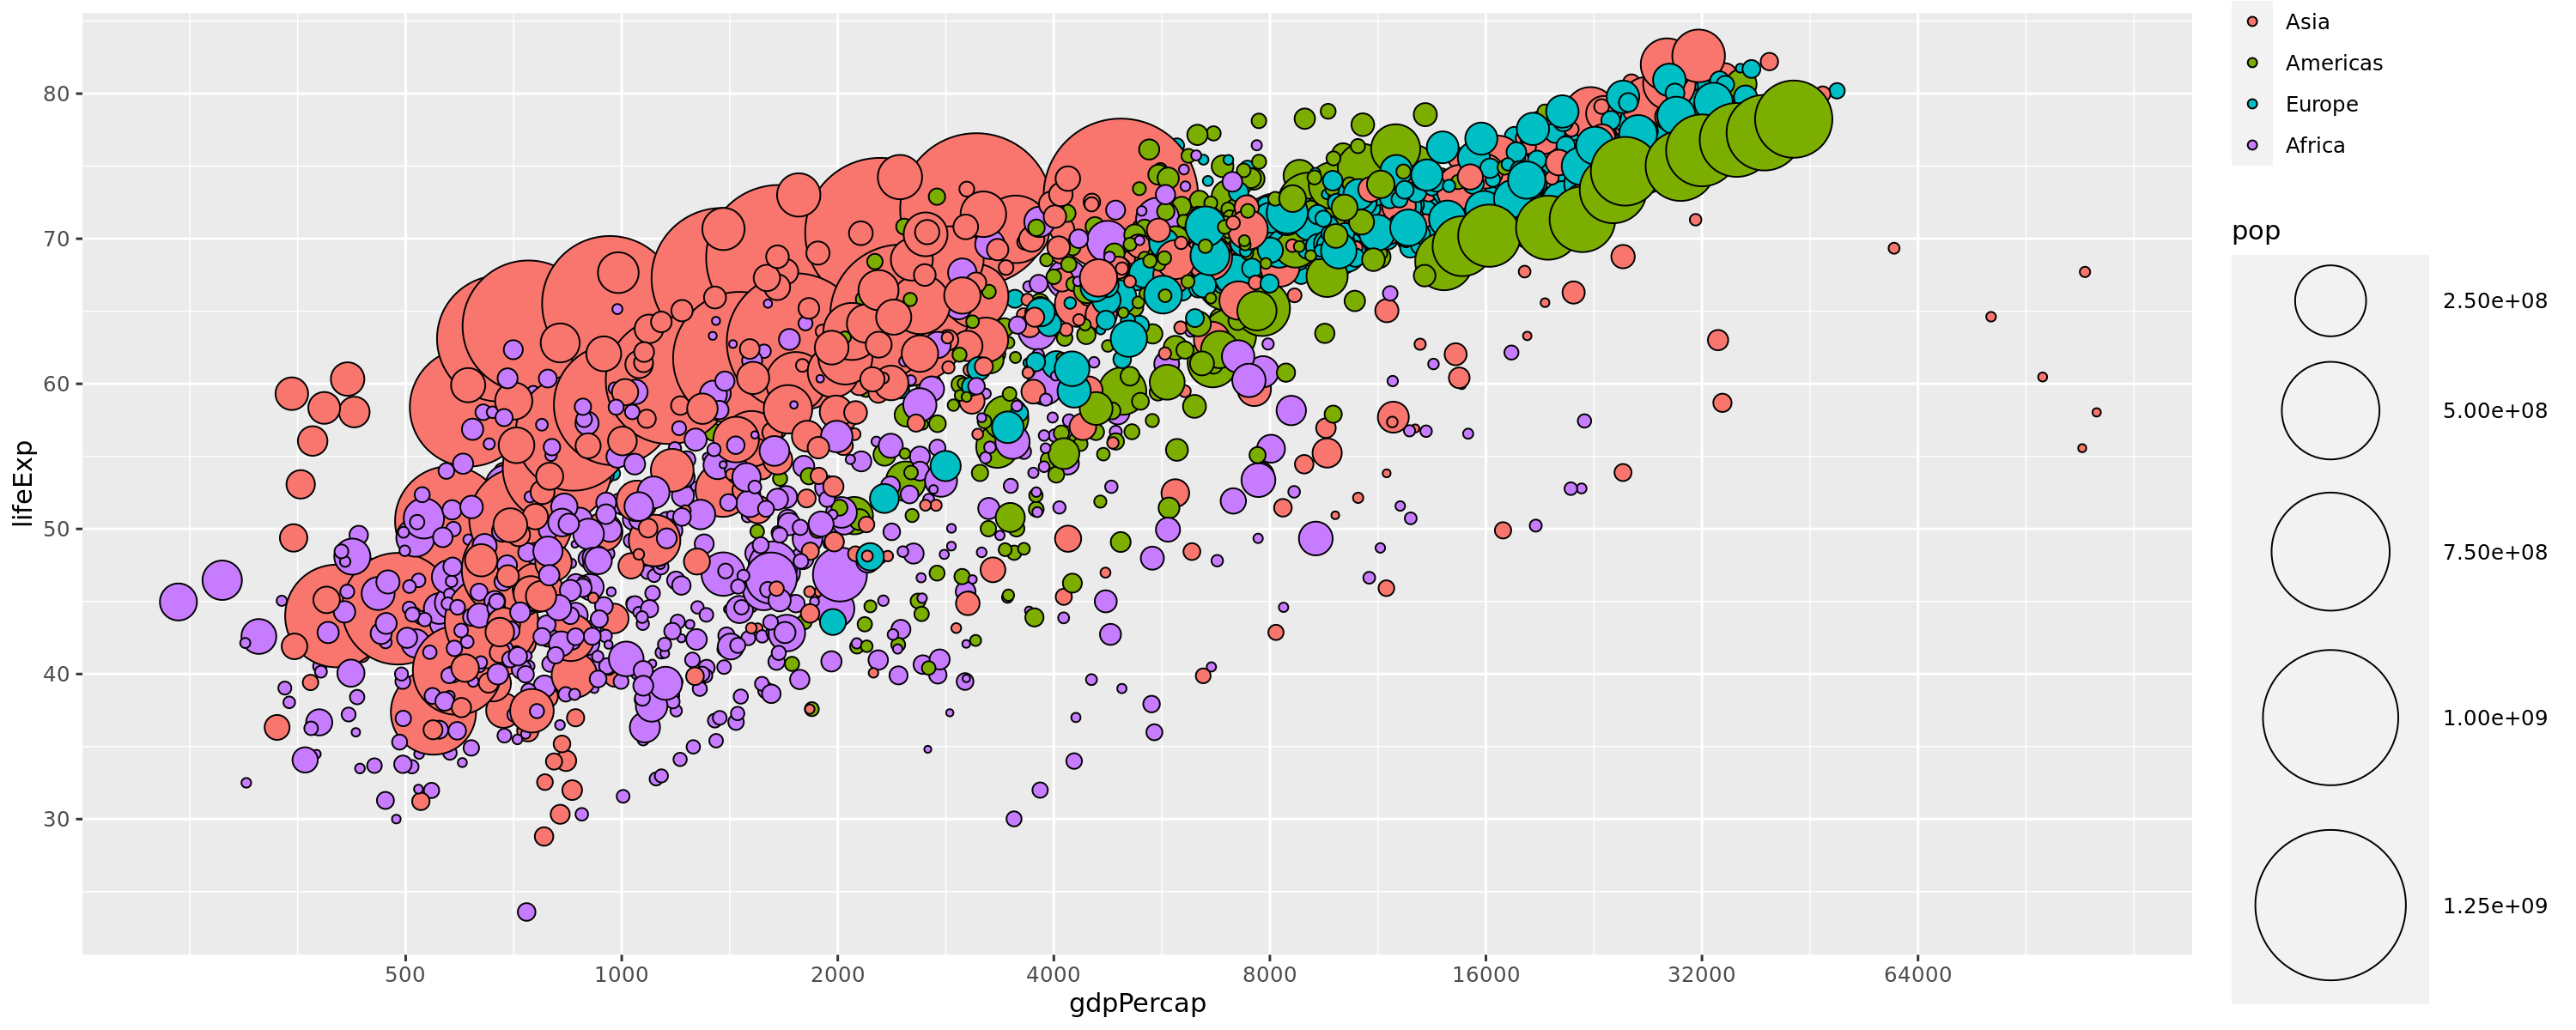

In [25]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) 
  


#####  Maintenant, on retir les légendes pour aérer la figure



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


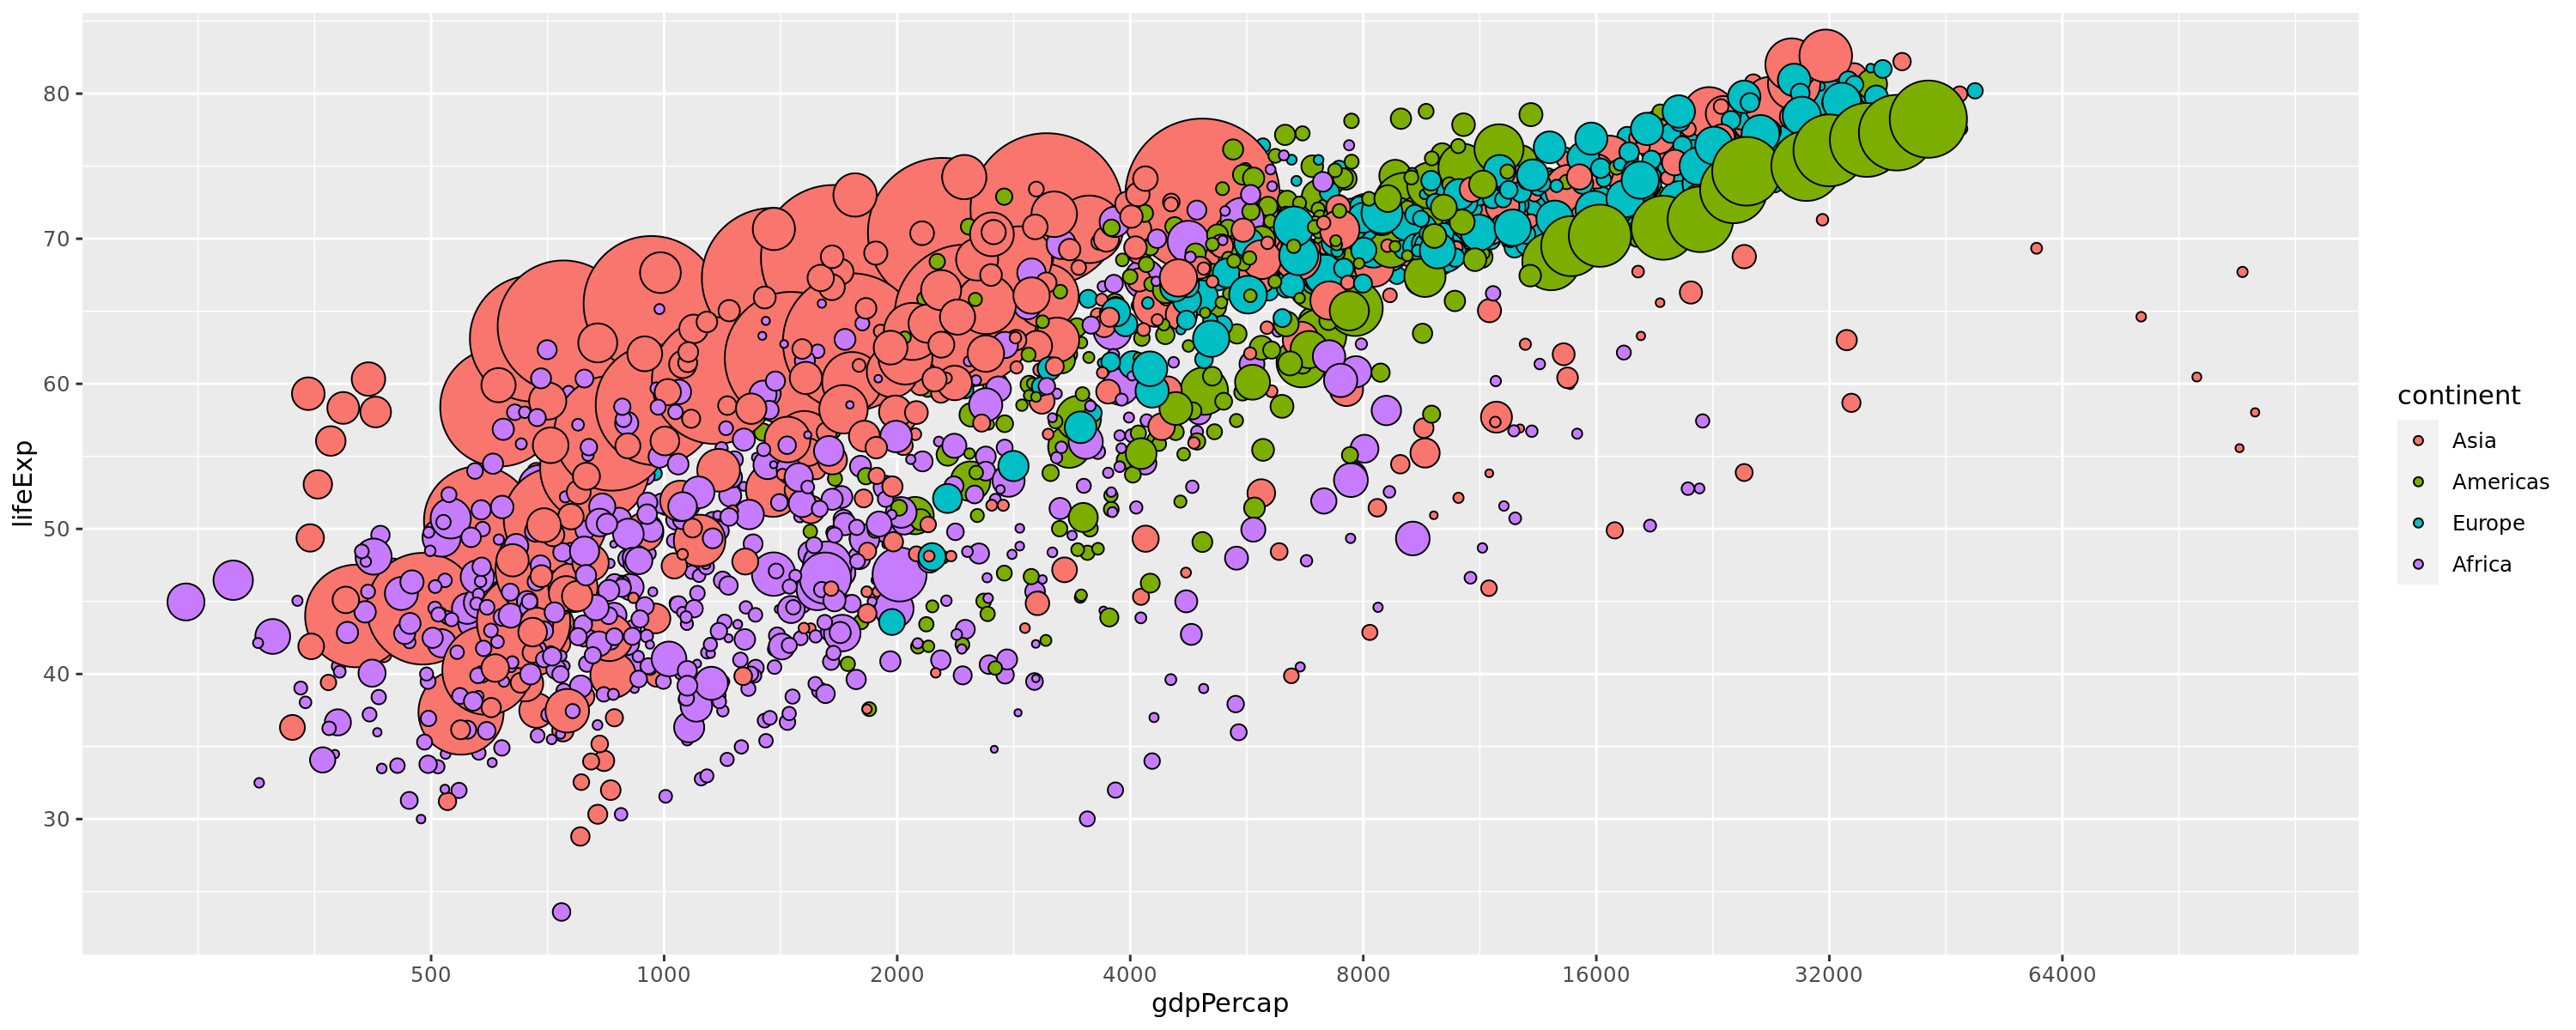

In [26]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) 
  


##### rajoutons les titres des axes et retirer le fond gris



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


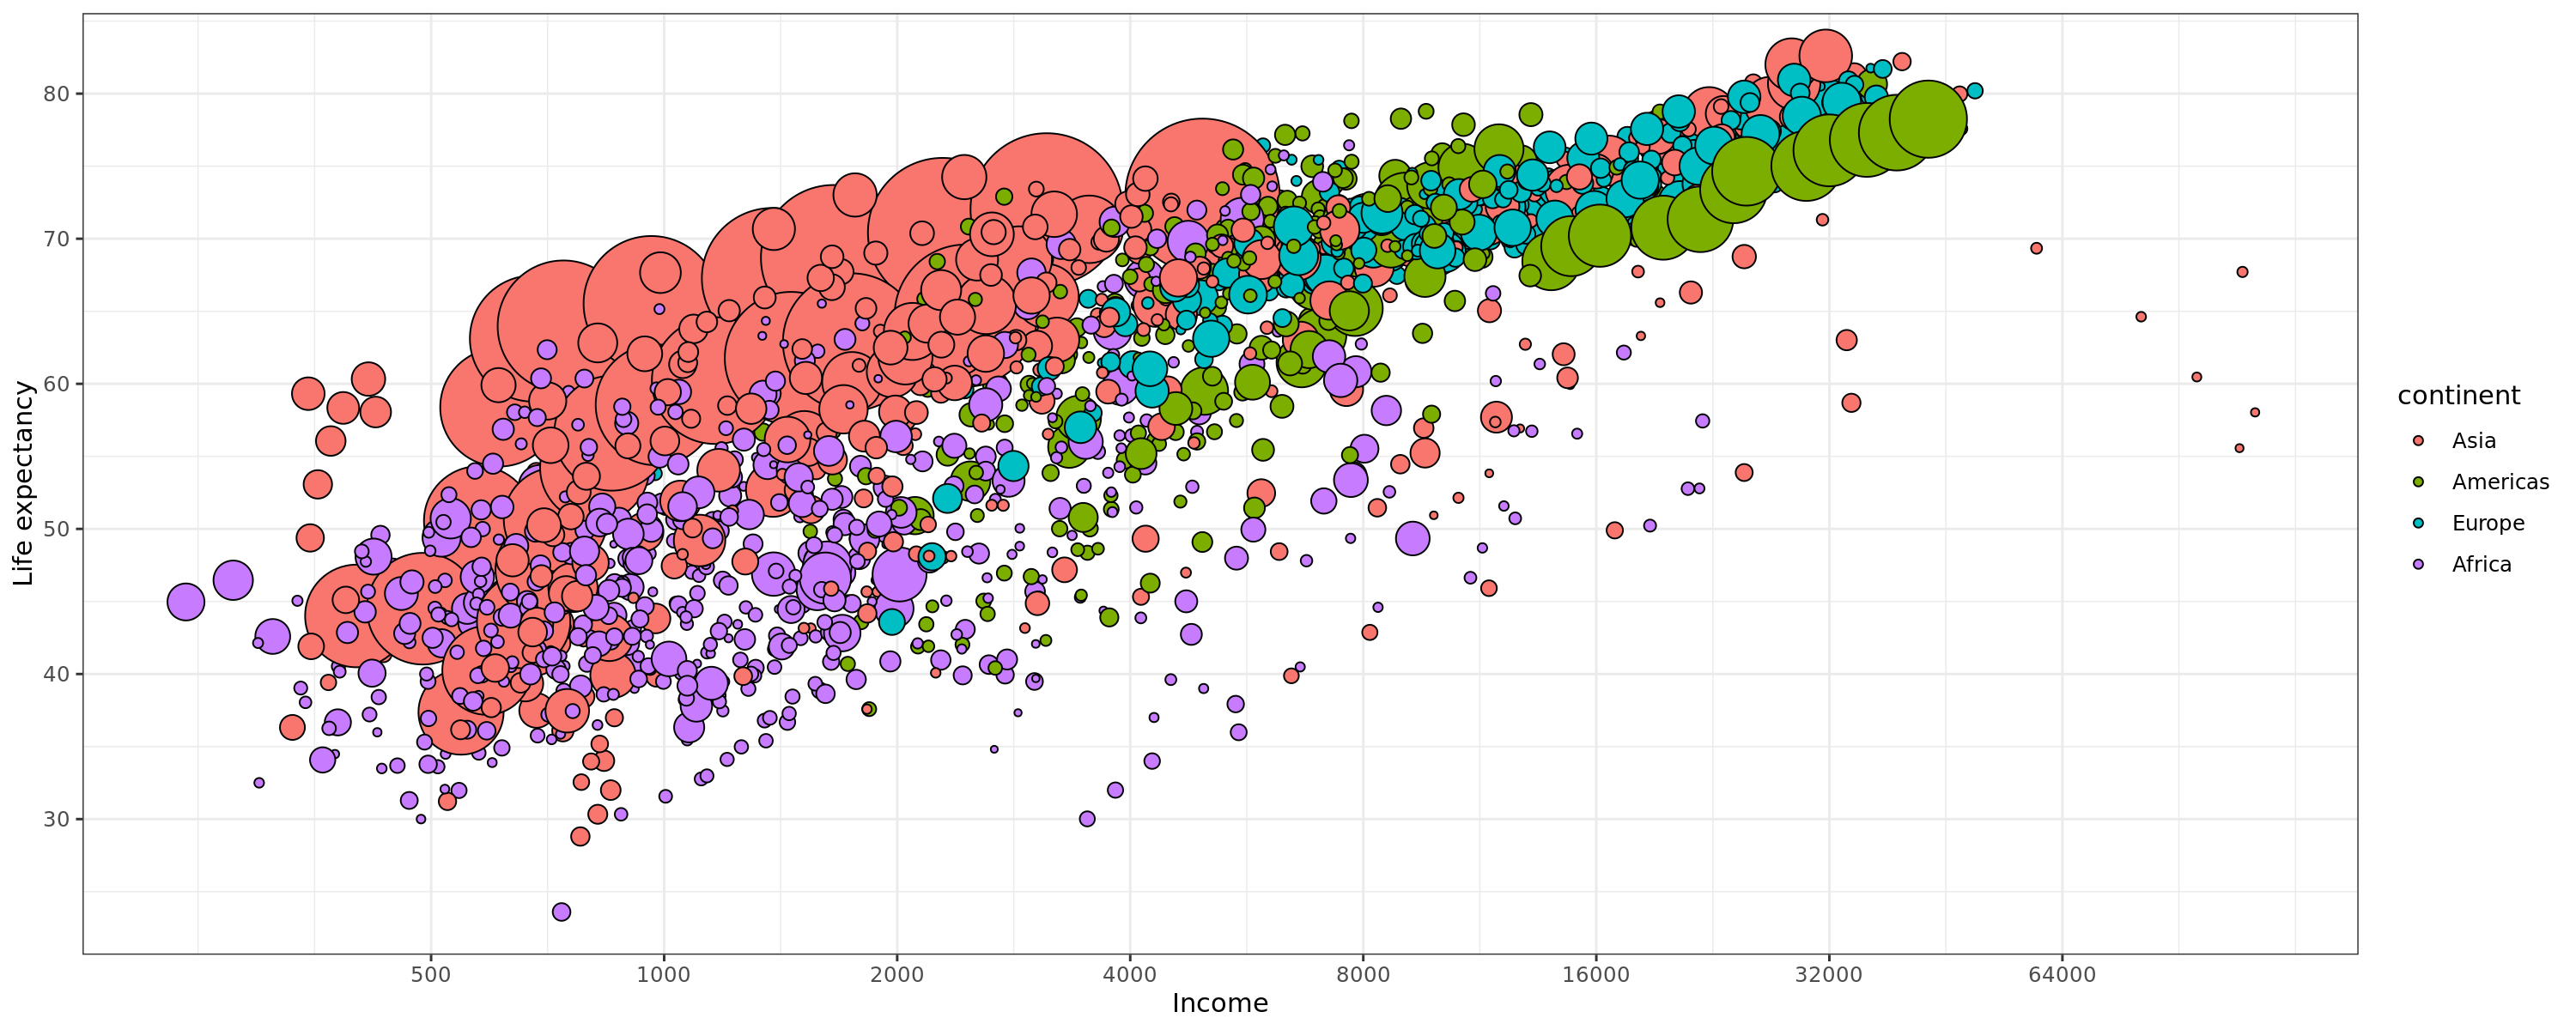

In [27]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

theme_set(theme_bw()) # Retire le fond gris


gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) 
  


##### Affichons l'année des données



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


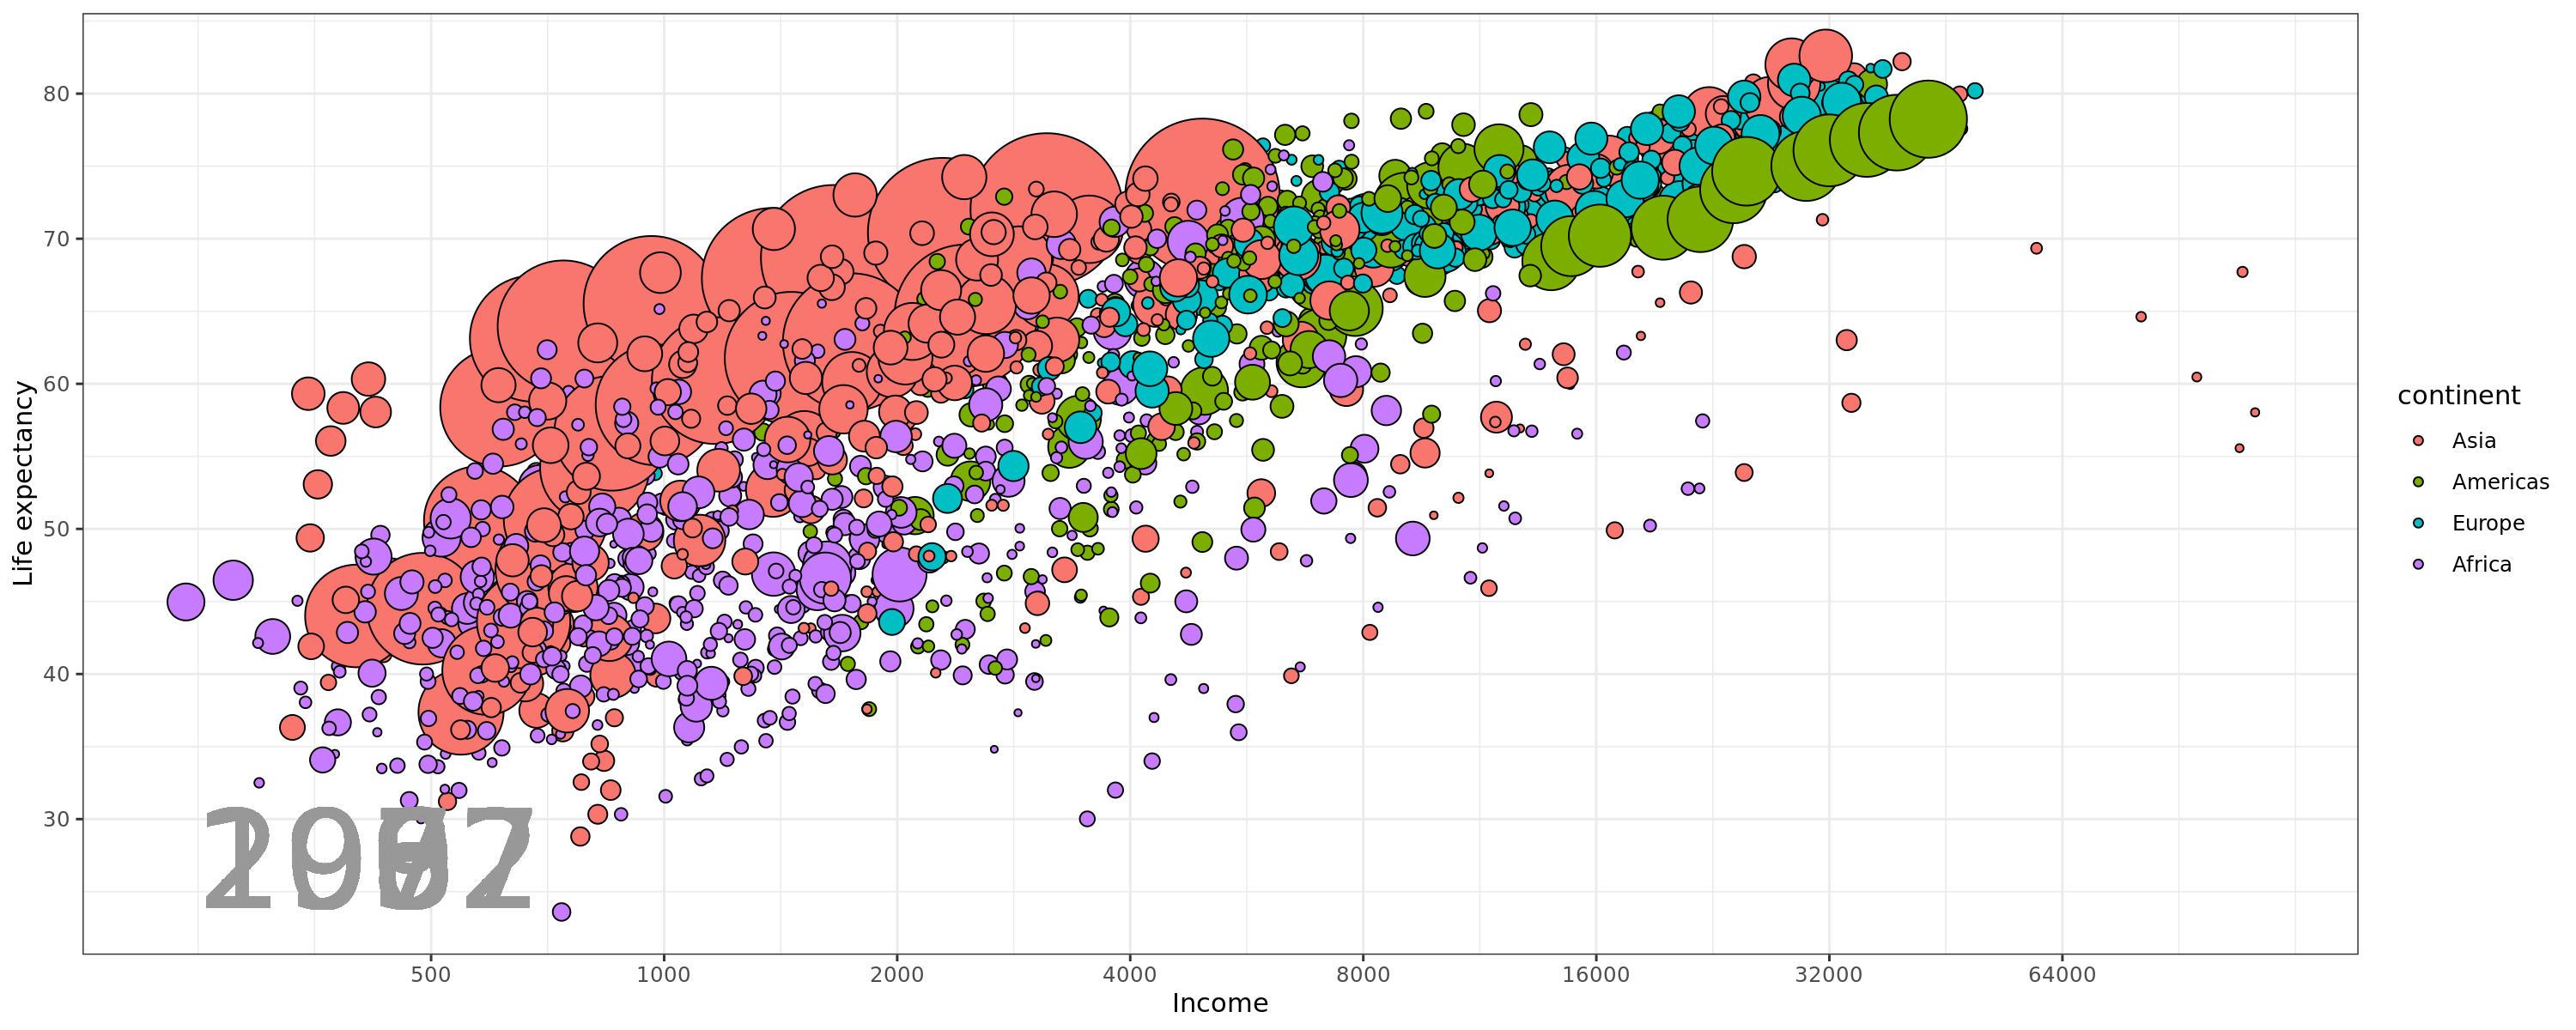

In [28]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

library(ggpp)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) 
  
  
  


##### Affichons le nom des pays (Ici uniquement la France)



In [29]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

library(ggrepel)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) 
  


ERROR: Error in library(ggrepel): there is no package called ‘ggrepel’


##### Ajustons le thème du graphique



In [30]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) +
  theme(plot.margin = margin(25, 25, 10, 25),    
        plot.title = element_text(color = "#22292F", hjust = 0,                              
                                  margin = margin(b = 15),                              
                                  size = 30,                              
                                  face = "bold"
                                  )) 
  


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


ERROR: Error in geom_label_repel(aes(label = country_label), show.legend = F, : could not find function "geom_label_repel"


##### Rajoutons un titre pour le graphique

`


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


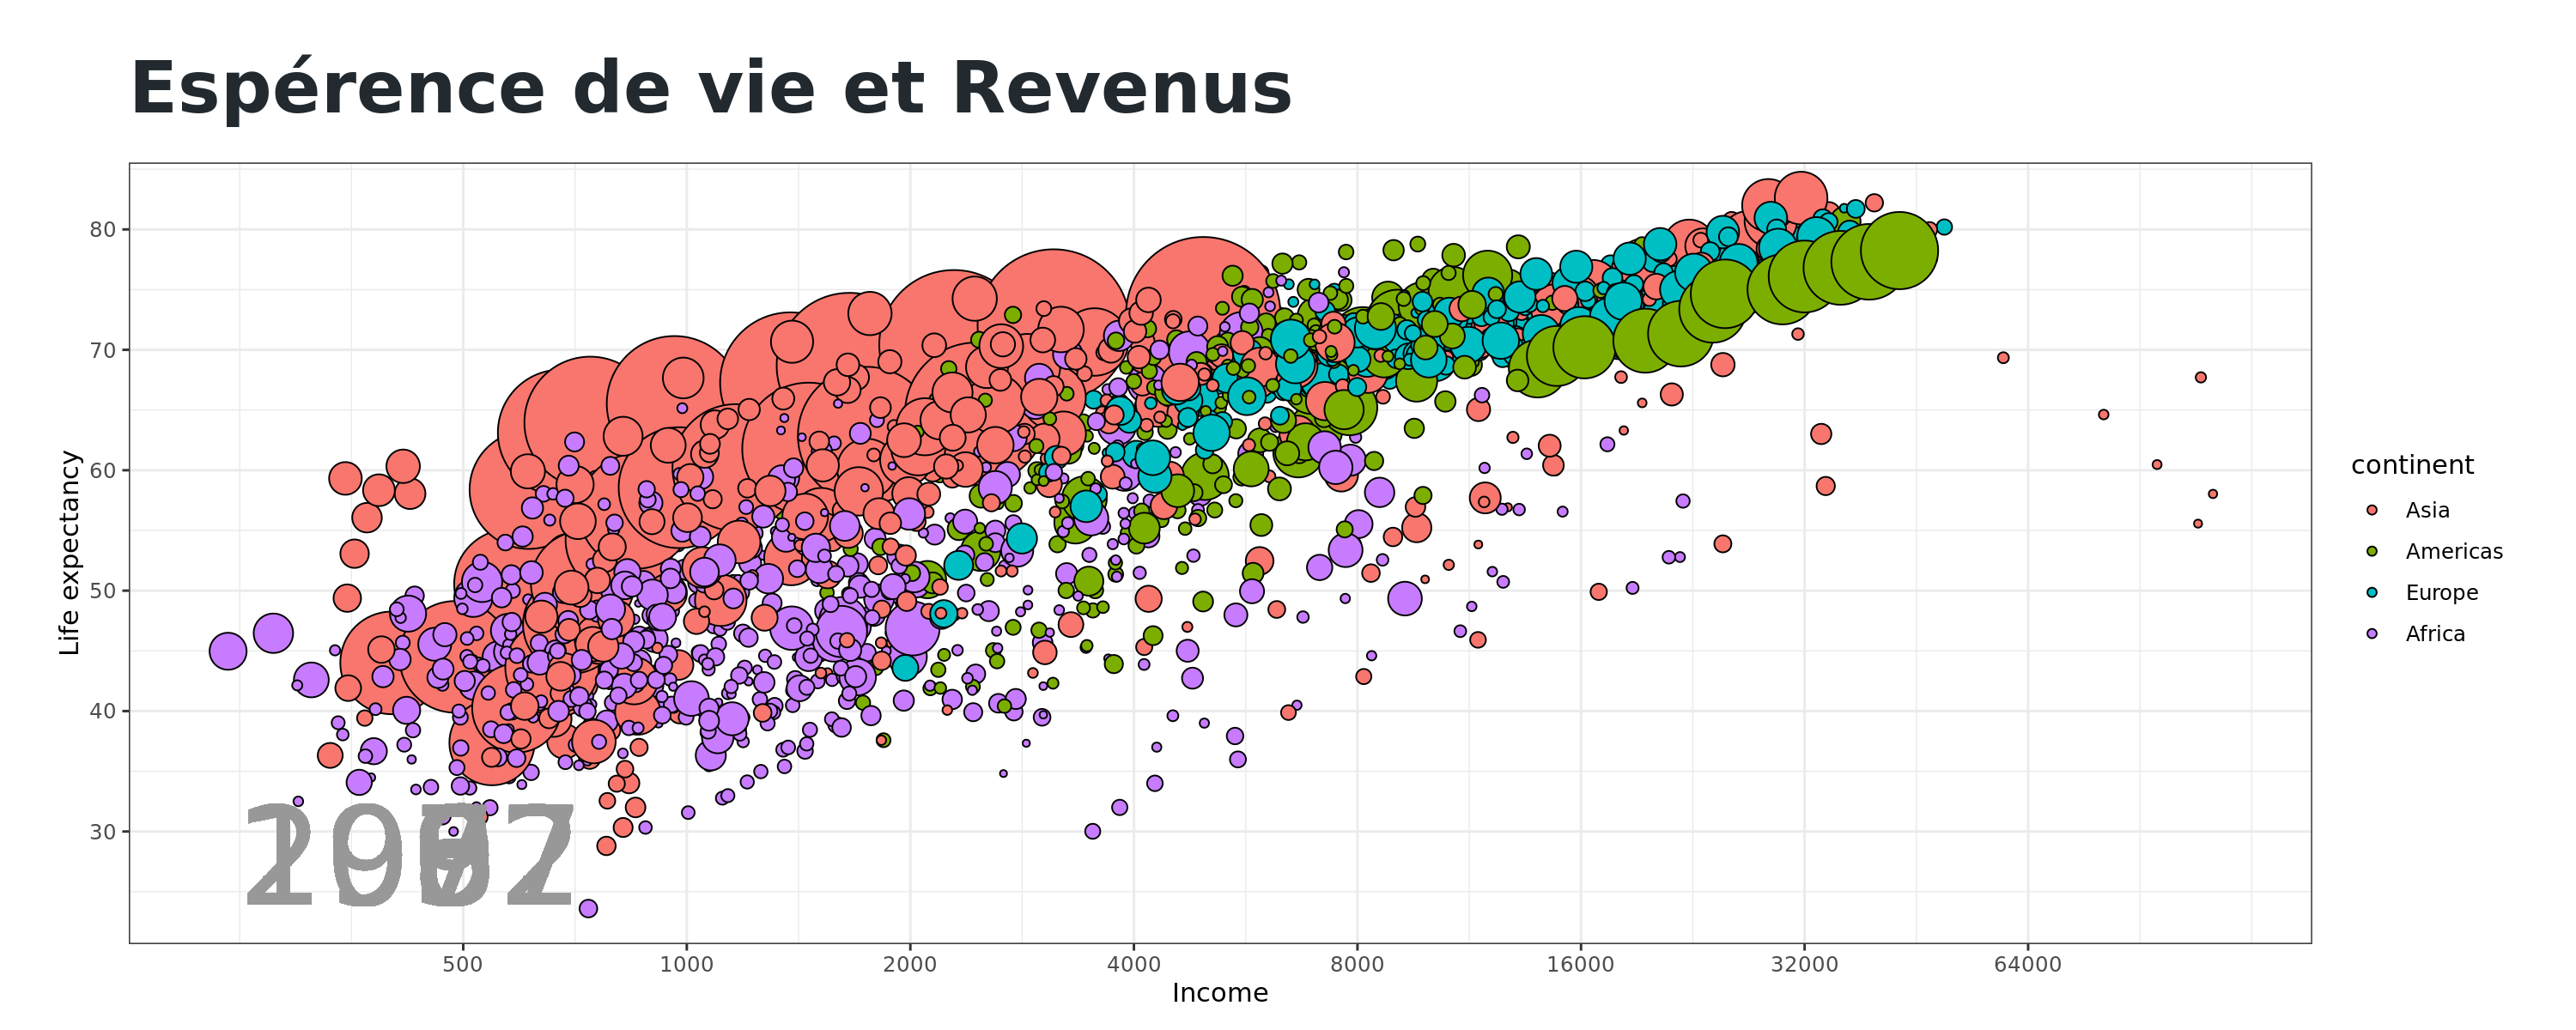

In [32]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) +
  theme(plot.margin = margin(25, 25, 10, 25),    
        plot.title = element_text(color = "#22292F", hjust = 0,                              
                                  margin = margin(b = 15),                              
                                  size = 30,                              
                                  face = "bold"
                                  )) +

  labs(title = "Espérence de vie et Revenus") 


##### Affichons la légende sous forme d'une carte du monde en bas à droite et retirons ma légende de gauche



In [34]:
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 200)

library(countrycode)
library(ggthemes)

world <- 
  map_data("world") %>%
  filter(region != "Antarctica") %>% 
  mutate(
    continent = countrycode(sourcevar = region,
                            origin = "country.name",
                            destination = "continent"),
    continent = case_when(
      continent == "Oceania" ~ "Asia",
      TRUE ~ as.character(continent)
    ) %>% as.factor %>% 
      fct_relevel("Asia", "Americas", "Europe", "Africa")
  ) %>% 
  drop_na(continent)

head(world, 10)


continent_map <- 
    ggplot(data = world) +   
      geom_map(map = world,
               aes(long, lat, 
                   group = group, 
                   map_id = region,
                   fill = continent)) +
     theme_map() +
     # coord_map(xlim = c(-180, 180),
     #           ylim = c(-200, 200)) +
     scale_fill_manual(values = c("#F15772", "#7EEB03", "#FBE700", "#54D5E9")) +  
    guides(fill = FALSE) +  
    theme(plot.background = element_blank())


  gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) +
  theme(plot.margin = margin(25, 25, 10, 25),    
        plot.title = element_text(color = "#22292F", hjust = 0,                              
                                  margin = margin(b = 15),                              
                                  size = 30,                              
                                  face = "bold"
                                  ),
        legend.position = "none"
        ) +

  labs(title = "Espérence de vie et Revenus") +
  annotate("plot_npc", npcx = "right", npcy = "bottom", label = continent_map)


ERROR: Error: The `maps` package is required for `map_data()`


##### Affichons chaque continent sur un graphe



In [35]:
library(gganimate)

gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) +
 theme(plot.margin = margin(25, 25, 10, 25),    
        plot.title = element_text(color = "#22292F", hjust = 0,                              
                                  margin = margin(b = 15),                              
                                  size = 30,                              
                                  face = "bold"
                                  ),
        legend.position = "none"
        ) +

  labs(title = "Espérence de vie et Revenus") +
  annotate("plot_npc", npcx = "right", npcy = "bottom", label = continent_map) +
  facet_wrap(~ continent)

  
  
  


ERROR: Error in library(gganimate): there is no package called ‘gganimate’


##### Et si on rajoutait un peu d'animation!



In [37]:
library(gganimate)


final_result <-
  gapminder_plot +
  scale_x_log10(breaks = c(500, 1000, 2000, 4000,
                           8000, 16000, 32000, 64000)) +
  scale_y_continuous(breaks = seq(0, 90, by = 10)) +
  scale_color_manual(values = c("#F15772", "#7EEB03",
                                "#FBE700", "#54D5E9")) +
  scale_size_continuous(range = c(1, 30)) +
  guides(size = FALSE, color = FALSE) +
  labs( x = "Income",    y = "Life expectancy"  ) +
  geom_text_npc(aes(label = year_label), 
                npcx = "left", npcy = "bottom", 
                size = 20, color = "#999999", alpha = .3,
                family = "Helvetica Neue"
                ) +
  geom_label_repel(aes(label = country_label), show.legend = F,
                   max.overlaps = 200) +
  theme(plot.margin = margin(25, 25, 10, 25),    
        plot.title = element_text(color = "#22292F", hjust = 0,                              
                                  margin = margin(b = 15),                              
                                  size = 30,                              
                                  face = "bold"
                                  ),
        legend.position = "none"
        ) +

  labs(title = "Espérence de vie et Revenus") +
  annotate("plot_npc", npcx = "right", npcy = "bottom", label = continent_map) +
  gganimate::transition_time(year) +
  gganimate::exit_fade()

final_result


ERROR: Error in library(gganimate): there is no package called ‘gganimate’


On peut modifier certaines propriétés pour les deux titres d'axe et d'autres uniquement pour l'un d'entre eux ou des propriétés pour chacun d'entre eux :


##### Enregistrer le résultat final


In [19]:
library(gganimate)

anim_save("final_result.gif",
          # path = "/",
          res = 200, 
          animation = final_result,
          # fps = 25
          # fps = 10,
          width = 800, 
          height = 700
)


ERROR: Error in library(gganimate): there is no package called ‘gganimate’


##### Ressources supplémentaires


* ["ggplot2: Elegant Graphics for Data Analysis"](https://ggplot2-book.org/) by Hadley Wickham, available via open-access!
* ["Fundamentals of Data Visualization"](http://serialmentor.com/dataviz/) by Claus O. Wilke about data visualization in general but using `{ggplot2}`. (You can find the codes on [his GitHub profile](https://github.com/clauswilke/dataviz).)
* ["Cookbook for R"](http://www.cookbook-r.com/Graphs/)
by Winston Chang with recipes to produce R plots
* Gallery of the [Top 50 ggplot2 visualizations](http://r-statistics.co/Top50-Ggplot2-Visualizations-MasterList-R-Code.html)
* Gallery of [`{ggplot2}` extension packages](https://exts.ggplot2.tidyverse.org/gallery/)
* [How to extend `{ggplot2}`](https://cran.r-project.org/web/packages/ggplot2/vignettes/extending-ggplot2.html) by Hadley Wickham
* The fantastic [R4DS Online Learning Community](https://www.rfordatasci.com/) that offers help and mentoring for all things related to the content of the ["R for Data Science" book](r4ds.had.co.nz/) by Hadley Wickham
* [#TidyTuesday](https://github.com/rfordatascience/tidytuesday), a weekly social data project focusing on ggplots—check also [#TidyTuesday on Twitter](https://twitter.com/hashtag/TidyTuesday?lang=en) and [this collection of contributions by Neil Grantham](https://nsgrantham.com/tidytuesdayrocks/)
* A two-part, 4.5-hours tutorial series by Thomas Linn Pedersen ([Part 1](https://www.youtube.com/watch?v=h29g21z0a68) | [Part 2](https://www.youtube.com/watch?v=0m4yywqNPVY))


In [ ]:
sessionInfo()




</details>
